In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import xgboost as xgb
import time

from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from cc_preprocessor import Preprocessor

np.random.seed(42)

In [2]:
df = pd.read_csv('data/Training_TriGuard.csv')
df = df.dropna(subset=['subrogation'])

In [ ]:
pre = Preprocessor(smoothing_factor=5)

In [4]:
X = df.drop(columns=["subrogation"]).copy()
y = df["subrogation"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

In [5]:
y_train.value_counts(normalize=True)

subrogation
0.0    0.77141
1.0    0.22859
Name: proportion, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

subrogation
0.0    0.771296
1.0    0.228704
Name: proportion, dtype: float64

In [7]:
pre.fit(X_train, y_train)

X_train_proc = pre.transform(X_train)
X_test_proc = pre.transform(X_test)

X_test_proc = X_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)

Fitting Preprocessor...
Fit complete.
Transforming data...
Applying learned target encodings...
Transform complete.
Dropping final object/datetime columns: ['gender', 'living_status', 'claim_date', 'claim_day_of_week', 'accident_site', 'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color', 'accident_type', 'in_network_bodyshop', 'season']
Transforming data...
Applying learned target encodings...
Transform complete.
Dropping final object/datetime columns: ['gender', 'living_status', 'claim_date', 'claim_day_of_week', 'accident_site', 'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color', 'accident_type', 'in_network_bodyshop', 'season']


In [8]:
dmatrix_train = xgb.DMatrix(data=X_train_proc, enable_categorical=True, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test_proc, enable_categorical=True, label=y_test)

In [9]:
learning_objective = {'objective':'binary:logistic', 'seed': 42}
model = xgb.train(params = learning_objective, dtrain= dmatrix_train)

In [10]:
test_predictions = model.predict(dmatrix_test)
round_test_predictions = [round(p) for p in test_predictions]
print(f"Accuracy: {accuracy_score(y_test, round_test_predictions)}")
print(f"F1 Score: {f1_score(y_test, round_test_predictions)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, test_predictions)}") # Use probabilities
print(f"PR AUC (Average Precision): {average_precision_score(y_test, test_predictions)}") # Use probabilities
print(f"Precision: {precision_score(y_test, round_test_predictions)}")
print(f"Recall: {recall_score(y_test, round_test_predictions)}")

Accuracy: 0.8044444444444444
F1 Score: 0.4808259587020649
ROC AUC Score: 0.8261306141889954
PR AUC (Average Precision): 0.5696260479272405
Precision: 0.6120150187734669
Recall: 0.39595141700404857


In [11]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

In [12]:
print("Starting randomized search tuning...")
start_time = time.time()

# Define a larger parameter space
param_dist = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05],
    'n_estimators': [700, 900, 1100, 1300, 1500],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.05, 0.1, 0.2],
    'reg_lambda': [0.25, 0.5, 0.75, 1.0, 1.25]
}

# Use Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=150,               # Randomly sample 50 parameter sets
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_proc, y_train)

random_search_time = time.time() - start_time
print(f"Randomized search complete. Time taken: {random_search_time:.2f} seconds")

# Output the best parameters
print("\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation accuracy: {random_search.best_score_:.4f}")

Starting randomized search tuning...
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Randomized search complete. Time taken: 172.03 seconds

Best parameters:
  subsample: 0.75
  reg_lambda: 0.25
  reg_alpha: 0.1
  n_estimators: 1100
  max_depth: 3
  learning_rate: 0.01
  gamma: 0.1
  colsample_bytree: 0.6

Best cross-validation accuracy: 0.8143


In [13]:
best_model = random_search.best_estimator_
test_predictions_gs = best_model.predict(X_test_proc)
round_test_predictions_gs = [round(p) for p in test_predictions_gs]
print(f"Accuracy: {accuracy_score(y_test, round_test_predictions_gs)}")
print(f"F1 Score: {f1_score(y_test, round_test_predictions_gs)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, test_predictions_gs)}") # Use probabilities
print(f"PR AUC (Average Precision): {average_precision_score(y_test, test_predictions_gs)}") # Use probabilities
print(f"Precision: {precision_score(y_test, round_test_predictions_gs)}")
print(f"Recall: {recall_score(y_test, round_test_predictions_gs)}")

Accuracy: 0.8185185185185185
F1 Score: 0.524733268671193
ROC AUC Score: 0.6846946065875742
PR AUC (Average Precision): 0.41508280384815743
Precision: 0.6541717049576784
Recall: 0.4380566801619433


In [14]:
model_prior = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.06,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="auc"
)
model_prior.fit(X_train_proc, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [15]:
test_predictions_prior = model_prior.predict(X_test_proc)
round_test_predictions_prior = [round(p) for p in test_predictions_prior]
print(f"Accuracy: {accuracy_score(y_test, round_test_predictions_prior)}")
print(f"F1 Score: {f1_score(y_test, round_test_predictions_prior)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, test_predictions_prior)}") # Use probabilities
print(f"PR AUC (Average Precision): {average_precision_score(y_test, test_predictions_prior)}") # Use probabilities
print(f"Precision: {precision_score(y_test, round_test_predictions_prior)}")
print(f"Recall: {recall_score(y_test, round_test_predictions_prior)}")

Accuracy: 0.8061111111111111
F1 Score: 0.5068299576071597
ROC AUC Score: 0.675796958459497
PR AUC (Average Precision): 0.3930015643173538
Precision: 0.6058558558558559
Recall: 0.43562753036437246


In [16]:
# Output module, from model_citizens.ipynb
real_test = pd.read_csv("data/Testing_TriGuard.csv")

X_real_test_proc = pre.transform(real_test)
X_real_test_proc = X_real_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)
real_pred_proba = best_model.predict_proba(X_real_test_proc)[:, 1]
real_pred_label = (real_pred_proba >= 0.5).astype(int)

prediction = pd.DataFrame({
    "claim_number": real_test["claim_number"],
    "subrogation": real_pred_label
})

print(prediction.head())

Transforming data...
Applying learned target encodings...
Transform complete.
Dropping final object/datetime columns: ['gender', 'living_status', 'claim_date', 'claim_day_of_week', 'accident_site', 'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color', 'accident_type', 'in_network_bodyshop', 'season']
   claim_number  subrogation
0       3126034            0
1       7380142            0
2       4655051            0
3       6728725            1
4       9848460            0


In [17]:
prediction.to_csv("results/vanilla_rs_prediction.csv", index=False)

## Beyond Randomized Search XGBoost

In [18]:
import graphviz
import shap

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

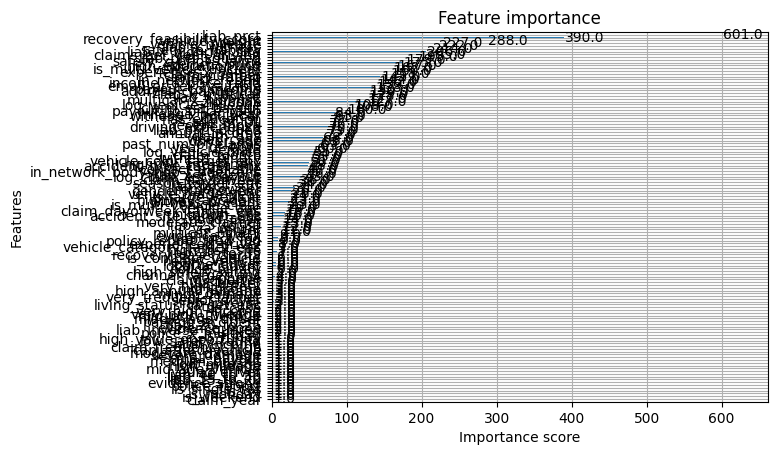

In [19]:
xgb.plot_importance(best_model)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

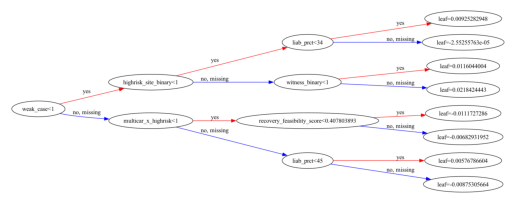

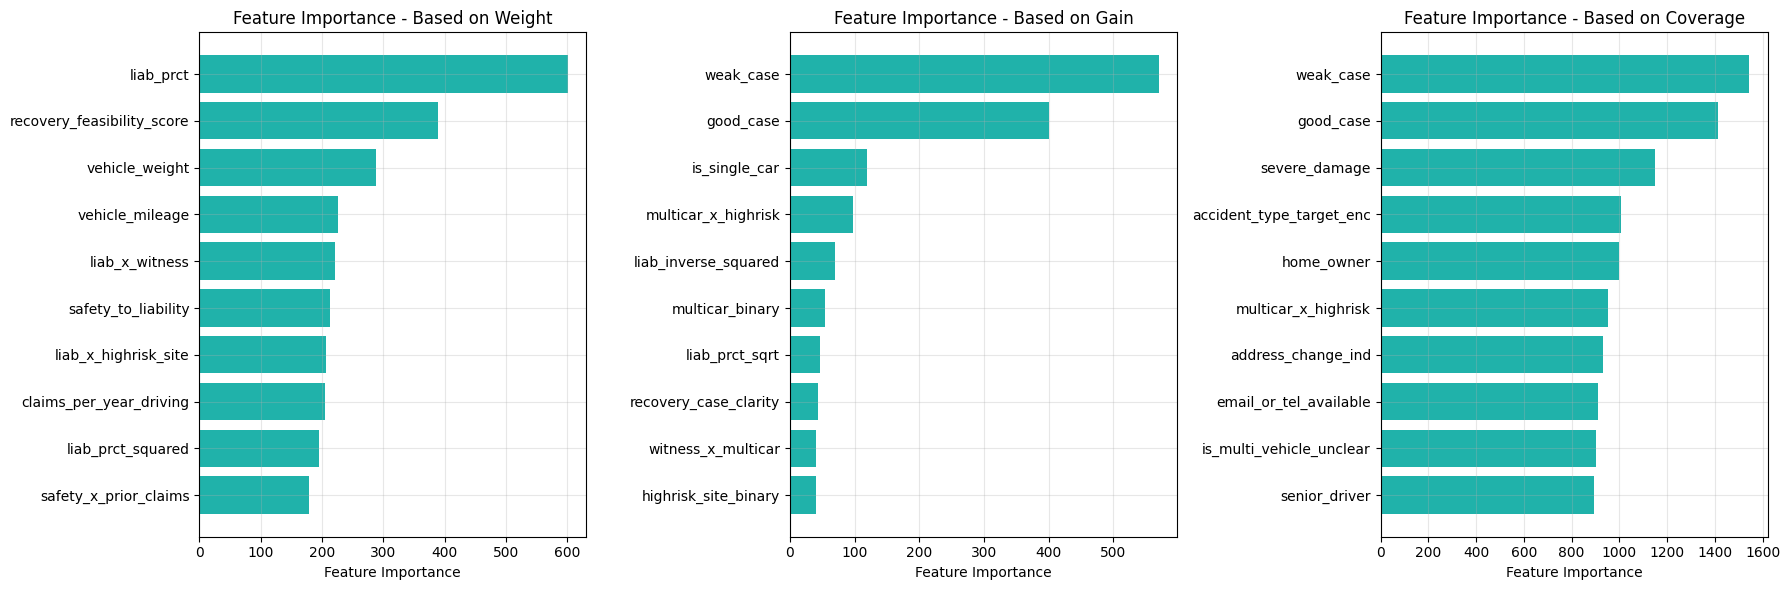

In [20]:
plt.figure(figsize=(20, 10))
xgb.plot_tree(best_model, num_trees=0, rankdir='LR')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

importance_types = ['weight', 'gain', 'cover']
titles = ['Based on Weight', 'Based on Gain', 'Based on Coverage']

for i, (imp_type, title) in enumerate(zip(importance_types, titles)):
    importance_dict = best_model.get_booster().get_score(importance_type=imp_type)
    importance_series = pd.Series(importance_dict).sort_values(ascending=True)
    
    if len(importance_series) > 10:
        importance_series = importance_series.tail(10)
    
    axes[i].barh(importance_series.index, importance_series.values, color='lightseagreen')
    axes[i].set_xlabel('Feature Importance')
    axes[i].set_title(f'Feature Importance - {title}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

`scoring = 'roc_auc'` used in RandomizedSearchCV

In [21]:
print("Starting randomized search tuning...")
start_time = time.time()

# Define a larger parameter space
param_dist_2 = {
    'max_depth': [1, 2],
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [1000, 1100, 1300],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.2, 0.3, 0.4],
    'gamma': [0, 0.05, 0.1, 0.15],
    'reg_alpha': [0.5, 0.7, 1.0, 1.5],
    'reg_lambda': [0.75, 1.0, 1.25]
}

# Use Randomized Search
random_search_2 = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_2,
    n_iter=150,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_2.fit(X_train_proc, y_train)

random_search_2_time = time.time() - start_time
print(f"Randomized search complete. Time taken: {random_search_2_time:.2f} seconds")

# Output the best parameters
print("\nBest parameters:")
for param, value in random_search_2.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation accuracy: {random_search_2.best_score_:.4f}")

Starting randomized search tuning...
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Randomized search complete. Time taken: 80.40 seconds

Best parameters:
  subsample: 0.7
  reg_lambda: 1.0
  reg_alpha: 0.7
  n_estimators: 1300
  max_depth: 1
  learning_rate: 0.02
  gamma: 0.15
  colsample_bytree: 0.2

Best cross-validation accuracy: 0.8406


In [22]:
best_model_2 = random_search_2.best_estimator_
test_predictions_gs_2 = best_model_2.predict(X_test_proc)
round_test_predictions_gs_2 = [round(p) for p in test_predictions_gs_2]
print(f"Accuracy: {accuracy_score(y_test, round_test_predictions_gs_2)}")
print(f"F1 Score: {f1_score(y_test, round_test_predictions_gs_2)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, test_predictions_gs_2)}") # Use probabilities
print(f"PR AUC (Average Precision): {average_precision_score(y_test, test_predictions_gs_2)}") # Use probabilities
print(f"Precision: {precision_score(y_test, round_test_predictions_gs_2)}")
print(f"Recall: {recall_score(y_test, round_test_predictions_gs_2)}")

Accuracy: 0.8177777777777778
F1 Score: 0.525096525096525
ROC AUC Score: 0.685068845351906
PR AUC (Average Precision): 0.4142524390656818
Precision: 0.6499402628434886
Recall: 0.4404858299595142


In [23]:
# Output module, from model_citizens.ipynb
real_test = pd.read_csv("data/Testing_TriGuard.csv")

X_real_test_proc = pre.transform(real_test)
X_real_test_proc = X_real_test_proc.reindex(columns=X_train_proc.columns, fill_value=0)
real_pred_proba_2 = best_model_2.predict_proba(X_real_test_proc)[:, 1]
real_pred_label_2 = (real_pred_proba_2 >= 0.5).astype(int)

prediction_2 = pd.DataFrame({
    "claim_number": real_test["claim_number"],
    "subrogation": real_pred_label_2
})

print(prediction_2.head())

Transforming data...
Applying learned target encodings...
Transform complete.
Dropping final object/datetime columns: ['gender', 'living_status', 'claim_date', 'claim_day_of_week', 'accident_site', 'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color', 'accident_type', 'in_network_bodyshop', 'season']
   claim_number  subrogation
0       3126034            0
1       7380142            0
2       4655051            0
3       6728725            1
4       9848460            0


In [24]:
prediction.to_csv("results/roc_auc_rs_prediction.csv", index=False)

`scoring = 'average_precision'` used in RandomizedSearchCV

In [25]:
print("Starting randomized search tuning...")
start_time = time.time()

# Define a larger parameter space
param_dist = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05],
    'n_estimators': [700, 900, 1100, 1300, 1500],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.05, 0.1, 0.2],
    'reg_lambda': [0.25, 0.5, 0.75, 1.0, 1.25]
}

# Use Randomized Search
random_search_3 = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=150,
    cv=3,
    scoring='average_precision',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_3.fit(X_train_proc, y_train)

random_search_3_time = time.time() - start_time
print(f"Randomized search complete. Time taken: {random_search_3_time:.2f} seconds")

# Output the best parameters
print("\nBest parameters:")
for param, value in random_search_3.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation accuracy: {random_search_3.best_score_:.4f}")

Starting randomized search tuning...
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Randomized search complete. Time taken: 168.00 seconds

Best parameters:
  subsample: 0.75
  reg_lambda: 0.25
  reg_alpha: 0.1
  n_estimators: 1100
  max_depth: 3
  learning_rate: 0.01
  gamma: 0.1
  colsample_bytree: 0.6

Best cross-validation accuracy: 0.5983


Best cross-validation accuracy is bad - the scoring may not work

In [26]:
print("Starting randomized search tuning...")
start_time = time.time()

# Define a larger parameter space
param_dist_4 = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.005, 0.01, 0.015],
    'n_estimators': [1500, 1700, 2000, 2500],
    'colsample_bytree': [0.3, 0.4, 0.5],
    'subsample': [0.3, 0.4, 0.5],
    'reg_lambda': [0.75, 1.0, 1.25, 1.5],
    'reg_alpha': [1.0, 1.3, 1.5, 2.0],
    'gamma': [0, 0.1, 0.15, 0.2],
}

# Use Randomized Search
random_search_4 = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_4,
    n_iter=150,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_4.fit(X_train_proc, y_train)

random_search_4_time = time.time() - start_time
print(f"Randomized search complete. Time taken: {random_search_4_time:.2f} seconds")

# Output the best parameters
print("\nBest parameters:")
for param, value in random_search_4.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation accuracy: {random_search_4.best_score_:.4f}")

Starting randomized search tuning...
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Randomized search complete. Time taken: 155.15 seconds

Best parameters:
  subsample: 0.5
  reg_lambda: 1.0
  reg_alpha: 1.5
  n_estimators: 2000
  max_depth: 2
  learning_rate: 0.015
  gamma: 0.15
  colsample_bytree: 0.4

Best cross-validation accuracy: 0.5221


In [27]:
best_model_4 = random_search_4.best_estimator_
test_predictions_gs_4 = best_model_4.predict(X_test_proc)
round_test_predictions_gs_4 = [round(p) for p in test_predictions_gs_4]
print(f"Accuracy: {accuracy_score(y_test, round_test_predictions_gs_4)}")
print(f"F1 Score: {f1_score(y_test, round_test_predictions_gs_4)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, test_predictions_gs_4)}") # Use probabilities
print(f"PR AUC (Average Precision): {average_precision_score(y_test, test_predictions_gs_4)}") # Use probabilities
print(f"Precision: {precision_score(y_test, round_test_predictions_gs_4)}")
print(f"Recall: {recall_score(y_test, round_test_predictions_gs_4)}")

Accuracy: 0.8172222222222222
F1 Score: 0.5320056899004267
ROC AUC Score: 0.6895504760608697
PR AUC (Average Precision): 0.41638783290836767
Precision: 0.6418764302059496
Recall: 0.454251012145749
